In [1]:
import read_benchmarks as rb

In [2]:
directory = "../../results/"

# Icelake CPU results with NoGradMode set in torch_jit_module_forward
filepath_nograd_fix_1k = directory + "icelake_nograd/output_1000_fix/slurm-34050567.out"
filepath_nograd_fix_10k = directory + "icelake_nograd/output_10000_fix/slurm-34051232.out"

# ampere (A100 GPU) results with NoGradMode set in torch_jit_module_forward
filepath_nograd_fix_gpu_10k = directory + "ampere_nograd/output_10000_fix/slurm-34050397.out"
filepath_nograd_fix_gpu_100k = directory + "ampere_nograd/output_100000_fix/slurm-34051212.out"

# Comparison between gradients enabled, NoGradMode, and NoGradMode with a frozen model, on Sapphire Rapids CPUs
filepath_options_1k = directory + "sapphire_options_grad/output_1k/slurm-37212483.out"
filepath_options_10k = directory + "sapphire_options_grad/output_10k/slurm-37224854.out"

# Comparison between gradient enabled, NoGradMode, and NoGradMode with a frozen model, on ampere (A100 GPU)
filepath_options_gpu_10k = directory + "ampere_options_grad/output_10k/slurm-37429435.out"
filepath_options_gpu_100k = directory + "ampere_options_grad/output_100k/slurm-37431441.out"

# Comparison between InferenceMode and NoGradMode (both with a frozen model) on Sapphire Rapids CPUs
filepath_infer_1k = directory + "sapphire_infer/output_1k/slurm-37447583.out"
filepath_infer_10k = directory + "sapphire_infer/output_10k/slurm-37449094.out"

# Comparison between InferenceMode and NoGradMode (both with a frozen model) on ampere (A100 GPU)
filepath_infer_gpu_10k = directory + "ampere_infer/output_10k/slurm-37521108.out"
filepath_infer_gpu_100k = directory + "ampere_infer/output_100k/slurm-37521956.out"

# FTorch and Forpy on Sapphire Rapids CPUs

Output files here use a significantly modified version of run_benchmarks.sh to allow comparisons between not only Forpy and FTorch, but also switching off gradients and freezing the model, e.g.:

```bash
nrun=1000

# Run with gradients on
for n in {1,4,8};
do
    export OMP_NUM_THREADS=$n
    date;/usr/bin/time -v ./benchmarker_cgdrag_forpy ../cgdrag_model run_emulator_davenet      $nrun 10                           | tee cgdrag_forpy_$n.out;date
    date;/usr/bin/time -v ./benchmarker_cgdrag_torch ../cgdrag_model saved_cgdrag_model_cpu.pt $nrun 10 --explicit_reshape        | tee cgdrag_torch_explicit_$n.out;date
    date;/usr/bin/time -v ./benchmarker_cgdrag_torch ../cgdrag_model saved_cgdrag_model_cpu.pt $nrun 10                           | tee cgdrag_torch_implicit_$n.out;date

    date;/usr/bin/time -v ./benchmarker_resnet_forpy ../resnet_model resnet18                    $nrun 10        | tee resnet_forpy_$n.out;date
    date;/usr/bin/time -v ./benchmarker_resnet_torch ../resnet_model saved_resnet18_model_cpu.pt $nrun 10        | tee resnet_torch_$n.out;date
done

cd ../build_sapphire_options_nograd

# Run with gradients off
for n in {1,4,8};
do
    export OMP_NUM_THREADS=$n
    date;/usr/bin/time -v ./benchmarker_cgdrag_torch ../cgdrag_model saved_cgdrag_model_cpu.pt $nrun 10 --explicit_reshape | tee cgdrag_torch_explicit_$n.out;date
    date;/usr/bin/time -v ./benchmarker_cgdrag_torch ../cgdrag_model saved_cgdrag_model_cpu.pt $nrun 10                    | tee cgdrag_torch_implicit_$n.out;date
    date;/usr/bin/time -v ./benchmarker_resnet_torch ../resnet_model saved_resnet18_model_cpu.pt $nrun 10                  | tee resnet_torch_$n.out;date
done

# Run with gradients off and use frozen models
for n in {1,4,8};
do
    export OMP_NUM_THREADS=$n
    date;/usr/bin/time -v ./benchmarker_cgdrag_torch ../cgdrag_model saved_cgdrag_model_freeze_cpu.pt $nrun 10 --explicit_reshape | tee cgdrag_torch_explicit_freeze_$n.out;date
    date;/usr/bin/time -v ./benchmarker_cgdrag_torch ../cgdrag_model saved_cgdrag_model_freeze_cpu.pt $nrun 10                    | tee cgdrag_torch_implicit_freeze_$n.out;date
    date;/usr/bin/time -v ./benchmarker_resnet_torch ../resnet_model saved_resnet18_model_freeze_cpu.pt $nrun 10                  | tee resnet_torch_freeze_$n.out;date
done
```

In [3]:
# Create labels matching the order of tests in run_benchmarks.sh

cpu_options_labels = []

cpu_tests_grad = [
    "cgdrag_forpy",
    "cgdrag_torch_explicit",
    "cgdrag_torch_implicit",
    "resnet_forpy",
    "resnet_torch",
]

cpu_tests_nograd = [
    "cgdrag_torch_explicit",
    "cgdrag_torch_implicit",
    "resnet_torch",
]

cpu_tests_nograd_freeze = [
    "cgdrag_torch_explicit",
    "cgdrag_torch_implicit",
    "resnet_torch",
]
cpu_n_threads = ["1", "4", "8"]

for threads in cpu_n_threads:
    for test in cpu_tests_grad:
        cpu_options_labels.append(f"{test}_{threads}_grad")
for threads in cpu_n_threads:
    for test in cpu_tests_nograd:
        cpu_options_labels.append(f"{test}_{threads}_nograd")
for threads in cpu_n_threads:
    for test in cpu_tests_nograd_freeze:
        cpu_options_labels.append(f"{test}_{threads}_freeze")

In [4]:
benchmarks_options_1k = rb.read_slurm_walltime(filepath_options_1k, cpu_options_labels)
benchmarks_options_10k = rb.read_slurm_walltime(filepath_options_10k, cpu_options_labels)


# Scale by number of iterations
for key, value in benchmarks_options_1k.items():
    benchmarks_options_1k[key] = value / 1000

for key, value in benchmarks_options_10k.items():
    benchmarks_options_10k[key] = value / 10000

Reading: ../../results/sapphire_options_grad/output_1k/slurm-37212483.out
Reading: ../../results/sapphire_options_grad/output_10k/slurm-37224854.out


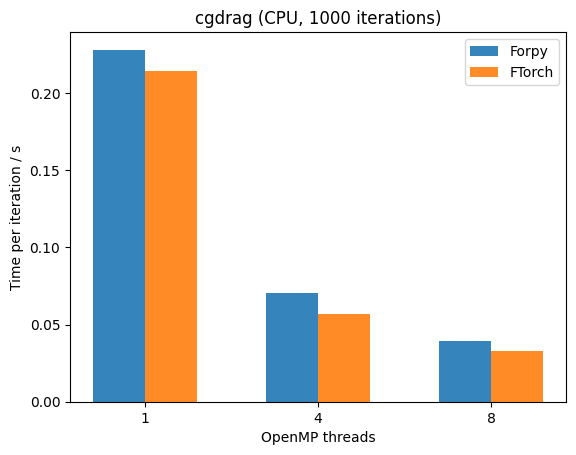

In [5]:
filtered_labels = [
    'cgdrag_forpy_1_grad',
    'cgdrag_torch_implicit_1_nograd',
    'cgdrag_forpy_4_grad',
    'cgdrag_torch_implicit_4_nograd',
    'cgdrag_forpy_8_grad',
    'cgdrag_torch_implicit_8_nograd',
]

rb.plot_walltimes(
    benchmarks=benchmarks_options_1k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="cgdrag (CPU, 1000 iterations)",

    legend_labels={"_grad": "Forpy", "_nograd": "FTorch"},
    xticklabels=cpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

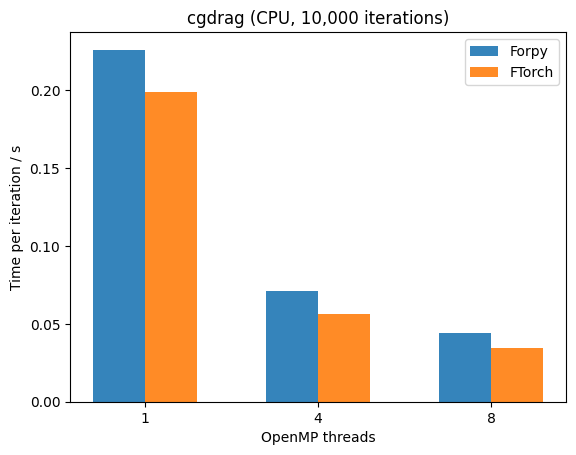

In [6]:
filtered_labels = [
    'cgdrag_forpy_1_grad',
    'cgdrag_torch_implicit_1_nograd',
    'cgdrag_forpy_4_grad',
    'cgdrag_torch_implicit_4_nograd',
    'cgdrag_forpy_8_grad',
    'cgdrag_torch_implicit_8_nograd',
]

rb.plot_walltimes(
    benchmarks=benchmarks_options_10k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="cgdrag (CPU, 10,000 iterations)",

    legend_labels={"_grad": "Forpy", "_nograd": "FTorch"},
    xticklabels=cpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

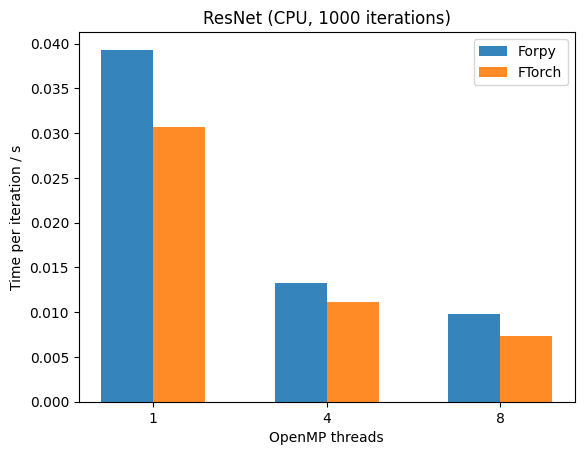

In [7]:
filtered_labels = [
    'resnet_forpy_1_grad',
    'resnet_torch_1_nograd',
    'resnet_forpy_4_grad',
    'resnet_torch_4_nograd',
    'resnet_forpy_8_grad',
    'resnet_torch_8_nograd',
]

rb.plot_walltimes(
    benchmarks=benchmarks_options_1k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="ResNet (CPU, 1000 iterations)",

    legend_labels={"_grad": "Forpy", "_nograd": "FTorch"},
    xticklabels=cpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

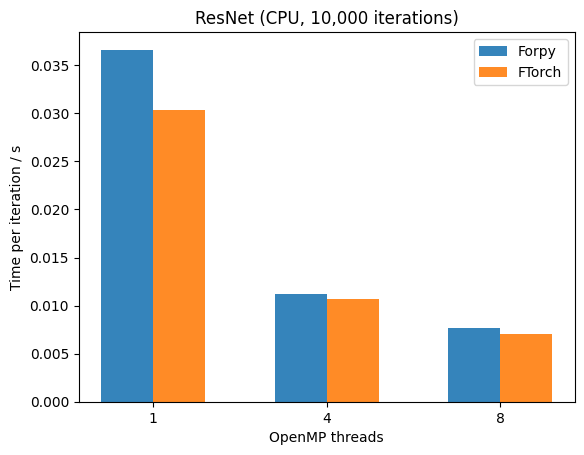

In [8]:
filtered_labels = [
    'resnet_forpy_1_grad',
    'resnet_torch_1_nograd',
    'resnet_forpy_4_grad',
    'resnet_torch_4_nograd',
    'resnet_forpy_8_grad',
    'resnet_torch_8_nograd',
]

rb.plot_walltimes(
    benchmarks=benchmarks_options_10k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="ResNet (CPU, 10,000 iterations)",

    legend_labels={"_grad": "Forpy", "_nograd": "FTorch"},
    xticklabels=cpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

# FTorch and Forpy on an A100 GPU

In [9]:
# Create labels matching the order of tests in run_benchmarks.sh

gpu_options_labels = []

gpu_tests_grad = [
    "cgdrag_forpy",
    "cgdrag_torch_explicit",
    "cgdrag_torch_implicit",
    "resnet_forpy",
    "resnet_torch",
]

gpu_tests_nograd = [
    "cgdrag_torch_explicit",
    "cgdrag_torch_implicit",
    "resnet_torch",
]

gpu_tests_nograd_freeze = [
    "cgdrag_torch_explicit",
    "cgdrag_torch_implicit",
    "resnet_torch",
]
gpu_n_threads = ["1", "8"]

for threads in gpu_n_threads:
    for test in gpu_tests_grad:
        gpu_options_labels.append(f"{test}_{threads}_grad")
for threads in gpu_n_threads:
    for test in gpu_tests_nograd:
        gpu_options_labels.append(f"{test}_{threads}_nograd")
for threads in gpu_n_threads:
    for test in gpu_tests_nograd_freeze:
        gpu_options_labels.append(f"{test}_{threads}_freeze")

In [10]:
benchmarks_options_gpu_10k = rb.read_slurm_walltime(filepath_options_gpu_10k, gpu_options_labels)
benchmarks_options_gpu_100k = rb.read_slurm_walltime(filepath_options_gpu_100k, gpu_options_labels)

# Scale by number of iterations
for key, value in benchmarks_options_gpu_10k.items():
    benchmarks_options_gpu_10k[key] = value / 10000

for key, value in benchmarks_options_gpu_100k.items():
    benchmarks_options_gpu_100k[key] = value / 100000

Reading: ../../results/ampere_options_grad/output_10k/slurm-37429435.out
Reading: ../../results/ampere_options_grad/output_100k/slurm-37431441.out


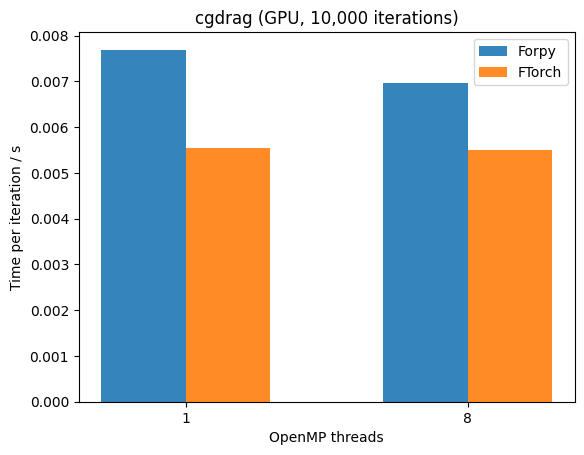

In [11]:
filtered_labels = [
    'cgdrag_forpy_1_grad',
    'cgdrag_torch_implicit_1_nograd',
    'cgdrag_forpy_8_grad',
    'cgdrag_torch_implicit_8_nograd',
]

rb.plot_walltimes(
    benchmarks=benchmarks_options_gpu_10k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="cgdrag (GPU, 10,000 iterations)",

    legend_labels={"_grad": "Forpy", "_nograd": "FTorch"},
    xticklabels=gpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

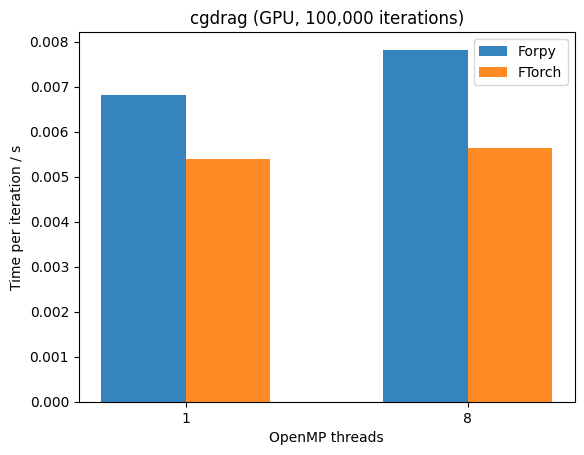

In [12]:
filtered_labels = [
    'cgdrag_forpy_1_grad',
    'cgdrag_torch_implicit_1_nograd',
    'cgdrag_forpy_8_grad',
    'cgdrag_torch_implicit_8_nograd',
]

rb.plot_walltimes(
    benchmarks=benchmarks_options_gpu_100k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="cgdrag (GPU, 100,000 iterations)",

    legend_labels={"_grad": "Forpy", "_nograd": "FTorch"},
    xticklabels=gpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

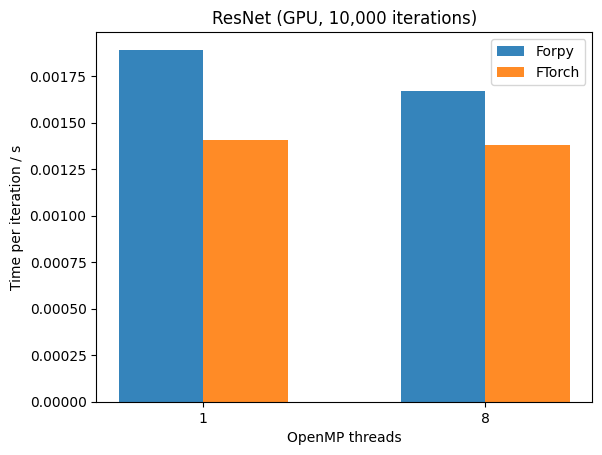

In [13]:
filtered_labels = [
    'resnet_forpy_1_grad',
    'resnet_torch_1_nograd',
    'resnet_forpy_8_grad',
    'resnet_torch_8_nograd',
]

rb.plot_walltimes(
    benchmarks=benchmarks_options_gpu_10k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="ResNet (GPU, 10,000 iterations)",

    legend_labels={"_grad": "Forpy", "_nograd": "FTorch"},
    xticklabels=gpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

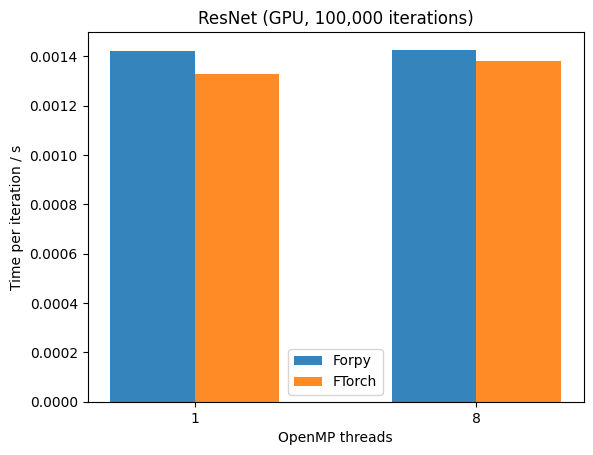

In [14]:
filtered_labels = [
    'resnet_forpy_1_grad',
    'resnet_torch_1_nograd',
    'resnet_forpy_8_grad',
    'resnet_torch_8_nograd',
]

rb.plot_walltimes(
    benchmarks=benchmarks_options_gpu_100k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="ResNet (GPU, 100,000 iterations)",

    legend_labels={"_grad": "Forpy", "_nograd": "FTorch"},
    xticklabels=gpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

# Summary of FTorch and Forpy on CPU and GPU

- Results for 10,000 steps, with 8 threads, from Sapphire Rapids CPUs and A100 GPUs.
- FTorch has NoGradMode enabled, but does not use a frozen model, as this requires further testing.

In [15]:
benchmarks_options_summary = {}
for benchmark in benchmarks_options_10k:
    if "forpy_8" in benchmark or ("torch" in benchmark and "8_nograd" in benchmark and "explicit" not in benchmark):
        benchmarks_options_summary[f"{benchmark}_cpu"] = benchmarks_options_10k[benchmark]

for benchmark in benchmarks_options_gpu_10k:
    if "forpy_8" in benchmark or ("torch" in benchmark and "8_nograd" in benchmark and "explicit" not in benchmark):
        benchmarks_options_summary[f"{benchmark}_gpu"] = benchmarks_options_gpu_10k[benchmark]

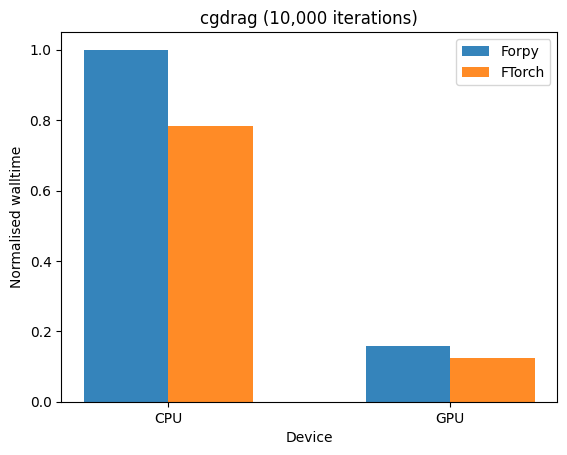

In [16]:
filtered_labels = [
    label for label in benchmarks_options_summary.keys() if "cgdrag" in label
]
rb.plot_walltimes(
    benchmarks=benchmarks_options_summary,
    labels=filtered_labels,
    ylabel="Normalised walltime",
    title="cgdrag (10,000 iterations)",

    legend_labels={"forpy": "Forpy", "torch": "FTorch"},
    xticklabels=["CPU", "GPU"],
    xlabel="Device",

    bar_width=0.3,
    normalise=True,
)

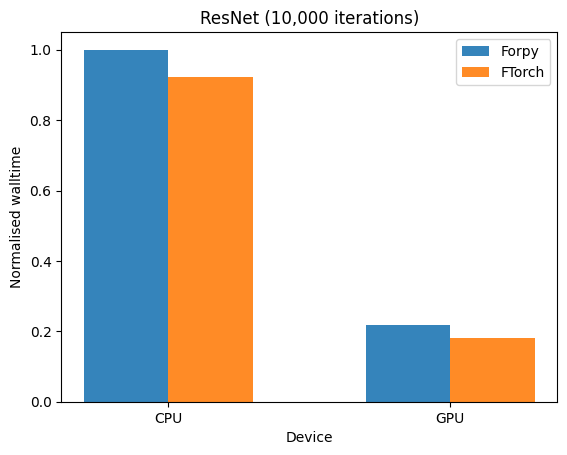

In [17]:
filtered_labels = [
    label for label in benchmarks_options_summary.keys() if "resnet" in label
]
rb.plot_walltimes(
    benchmarks=benchmarks_options_summary,
    labels=filtered_labels,
    ylabel="Normalised walltime",
    title="ResNet (10,000 iterations)",

    legend_labels={"forpy": "Forpy", "torch": "FTorch"},
    xticklabels=["CPU", "GPU"],
    xlabel="Device",

    bar_width=0.3,
    normalise=True,
)

# FTorch with/without gradients and/or frozen models on Sapphire Rapids CPUs

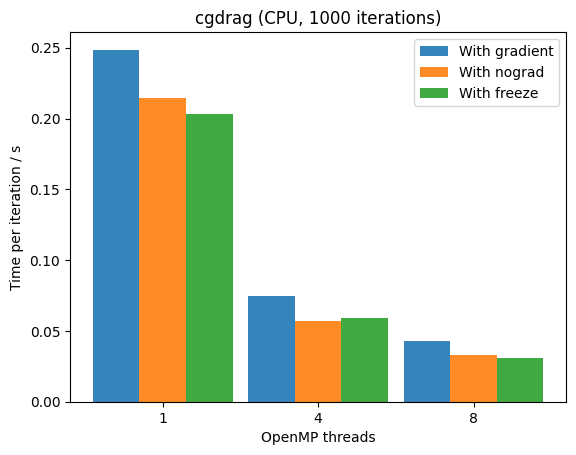

In [18]:
filtered_labels = [
    'cgdrag_torch_implicit_1_grad',
    'cgdrag_torch_implicit_1_nograd',
    'cgdrag_torch_implicit_1_freeze',
    'cgdrag_torch_implicit_4_grad',
    'cgdrag_torch_implicit_4_nograd',
    'cgdrag_torch_implicit_4_freeze',
    'cgdrag_torch_implicit_8_grad',
    'cgdrag_torch_implicit_8_nograd',
    'cgdrag_torch_implicit_8_freeze'
]

rb.plot_walltimes(
    benchmarks=benchmarks_options_1k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="cgdrag (CPU, 1000 iterations)",

    legend_labels={"_grad": "With gradient", "_nograd": "With nograd", "_freeze": "With freeze"},
    xticklabels=cpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

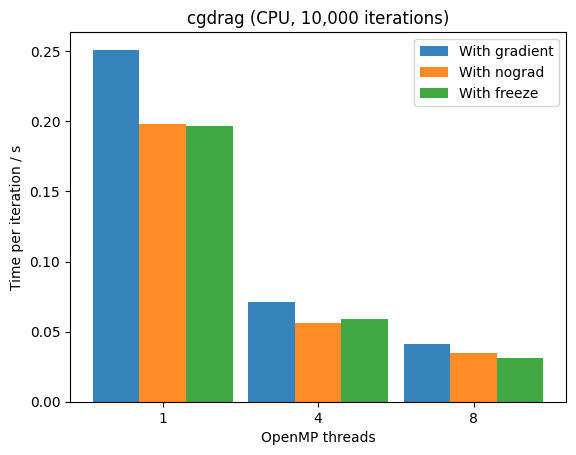

In [19]:
filtered_labels = [
    'cgdrag_torch_implicit_1_grad',
    'cgdrag_torch_implicit_1_nograd',
    'cgdrag_torch_implicit_1_freeze',
    'cgdrag_torch_implicit_4_grad',
    'cgdrag_torch_implicit_4_nograd',
    'cgdrag_torch_implicit_4_freeze',
    'cgdrag_torch_implicit_8_grad',
    'cgdrag_torch_implicit_8_nograd',
    'cgdrag_torch_implicit_8_freeze'
]

rb.plot_walltimes(
    benchmarks=benchmarks_options_10k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="cgdrag (CPU, 10,000 iterations)",

    legend_labels={"_grad": "With gradient", "_nograd": "With nograd", "_freeze": "With freeze"},
    xticklabels=cpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

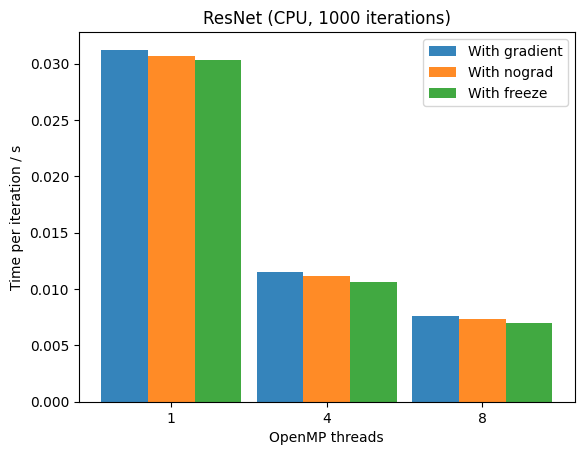

In [20]:
filtered_labels = [
    'resnet_torch_1_grad',
    'resnet_torch_1_nograd',
    'resnet_torch_1_freeze',
    'resnet_torch_4_grad',
    'resnet_torch_4_nograd',
    'resnet_torch_4_freeze',
    'resnet_torch_8_grad',
    'resnet_torch_8_nograd',
    'resnet_torch_8_freeze'
]

rb.plot_walltimes(
    benchmarks=benchmarks_options_1k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="ResNet (CPU, 1000 iterations)",

    legend_labels={"_grad": "With gradient", "_nograd": "With nograd", "_freeze": "With freeze"},
    xticklabels=cpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

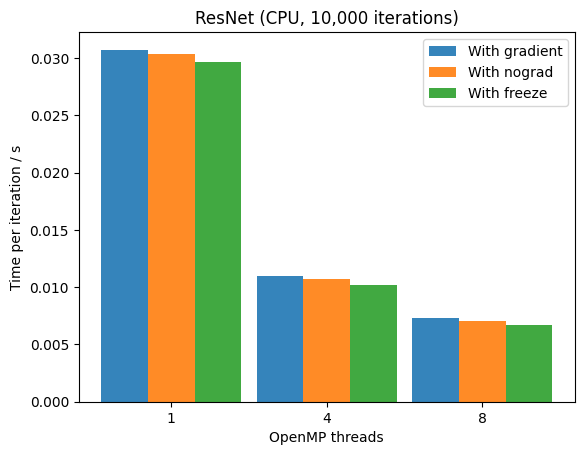

In [21]:
filtered_labels = [
    'resnet_torch_1_grad',
    'resnet_torch_1_nograd',
    'resnet_torch_1_freeze',
    'resnet_torch_4_grad',
    'resnet_torch_4_nograd',
    'resnet_torch_4_freeze',
    'resnet_torch_8_grad',
    'resnet_torch_8_nograd',
    'resnet_torch_8_freeze'
]

rb.plot_walltimes(
    benchmarks=benchmarks_options_10k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="ResNet (CPU, 10,000 iterations)",

    legend_labels={"_grad": "With gradient", "_nograd": "With nograd", "_freeze": "With freeze"},
    xticklabels=cpu_n_threads,
    xlabel="OpenMP threads",

    # legend_labels={"_1_": "1", "_4_": "4", "_8_": "8"},
    # xticklabels=["Forpy", "FTorch"],
    # xlabel="PyTorch interface",

    bar_width=0.3,
)

# FTorch with/without gradients and/or frozen models on an A100 GPU

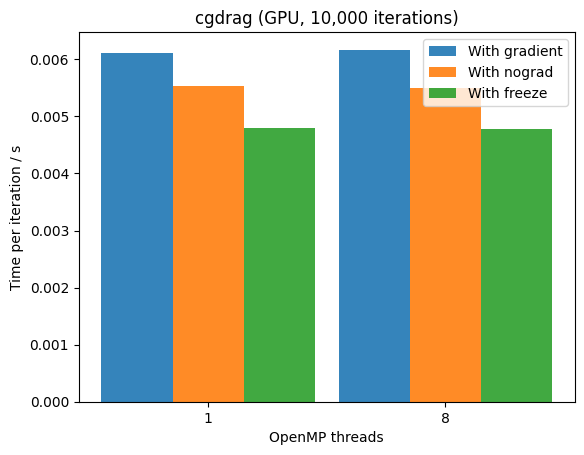

In [22]:
filtered_labels = [
    'cgdrag_torch_implicit_1_grad',
    'cgdrag_torch_implicit_1_nograd',
    'cgdrag_torch_implicit_1_freeze',
    'cgdrag_torch_implicit_8_grad',
    'cgdrag_torch_implicit_8_nograd',
    'cgdrag_torch_implicit_8_freeze'
]

rb.plot_walltimes(
    benchmarks=benchmarks_options_gpu_10k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="cgdrag (GPU, 10,000 iterations)",

    legend_labels={"_grad": "With gradient", "_nograd": "With nograd", "_freeze": "With freeze"},
    xticklabels=gpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

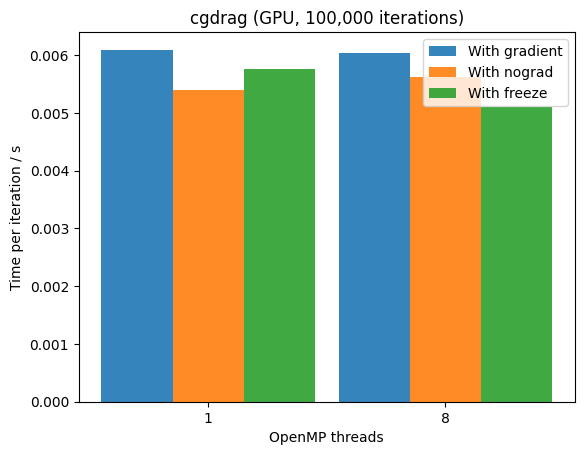

In [23]:
filtered_labels = [
    'cgdrag_torch_implicit_1_grad',
    'cgdrag_torch_implicit_1_nograd',
    'cgdrag_torch_implicit_1_freeze',
    'cgdrag_torch_implicit_8_grad',
    'cgdrag_torch_implicit_8_nograd',
    'cgdrag_torch_implicit_8_freeze'
]

rb.plot_walltimes(
    benchmarks=benchmarks_options_gpu_100k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="cgdrag (GPU, 100,000 iterations)",

    legend_labels={"_grad": "With gradient", "_nograd": "With nograd", "_freeze": "With freeze"},
    xticklabels=gpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

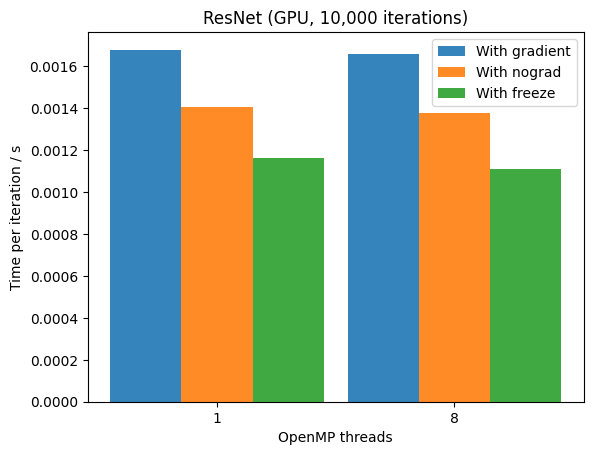

In [24]:
filtered_labels = [
    'resnet_torch_1_grad',
    'resnet_torch_1_nograd',
    'resnet_torch_1_freeze',
    'resnet_torch_8_grad',
    'resnet_torch_8_nograd',
    'resnet_torch_8_freeze'
]

rb.plot_walltimes(
    benchmarks=benchmarks_options_gpu_10k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="ResNet (GPU, 10,000 iterations)",

    legend_labels={"_grad": "With gradient", "_nograd": "With nograd", "_freeze": "With freeze"},
    xticklabels=gpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

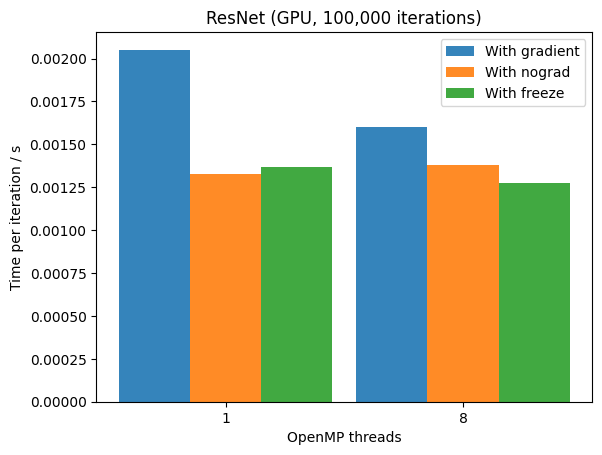

In [25]:
filtered_labels = [
    'resnet_torch_1_grad',
    'resnet_torch_1_nograd',
    'resnet_torch_1_freeze',
    'resnet_torch_8_grad',
    'resnet_torch_8_nograd',
    'resnet_torch_8_freeze'
]

rb.plot_walltimes(
    benchmarks=benchmarks_options_gpu_100k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="ResNet (GPU, 100,000 iterations)",

    legend_labels={"_grad": "With gradient", "_nograd": "With nograd", "_freeze": "With freeze"},
    xticklabels=gpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

# FTorch with InferenceMode and NoGradMode on Sapphire Rapids CPUs

In [26]:
# Create labels matching the order of tests in run_benchmarks.sh

cpu_infer_labels = []

cpu_tests_infer = [
    "cgdrag_torch_explicit",
    "cgdrag_torch_implicit",
    "resnet_torch",
]

cpu_tests_nograd = [
    "cgdrag_torch_explicit",
    "cgdrag_torch_implicit",
    "resnet_torch",
]

cpu_n_threads = ["1", "4", "8"]

for threads in cpu_n_threads:
    for test in cpu_tests_infer:
        cpu_infer_labels.append(f"{test}_{threads}_infer")
for threads in cpu_n_threads:
    for test in cpu_tests_nograd:
        cpu_infer_labels.append(f"{test}_{threads}_nograd")

In [27]:
benchmarks_infer_1k = rb.read_slurm_walltime(filepath_infer_1k, cpu_infer_labels)
benchmarks_infer_10k = rb.read_slurm_walltime(filepath_infer_10k, cpu_infer_labels)

# Scale by number of iterations
for key, value in benchmarks_infer_1k.items():
    benchmarks_infer_1k[key] = value / 1000

for key, value in benchmarks_infer_10k.items():
    benchmarks_infer_10k[key] = value / 10000

Reading: ../../results/sapphire_infer/output_1k/slurm-37447583.out
Reading: ../../results/sapphire_infer/output_10k/slurm-37449094.out


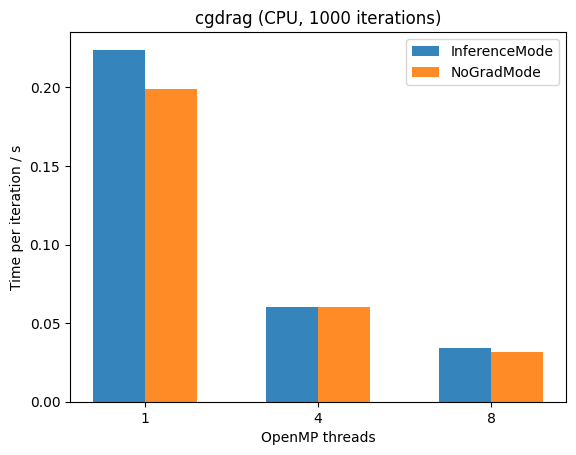

In [28]:
filtered_labels = [
    'cgdrag_torch_implicit_1_infer',
    'cgdrag_torch_implicit_1_nograd',
    'cgdrag_torch_implicit_4_infer',
    'cgdrag_torch_implicit_4_nograd',
    'cgdrag_torch_implicit_8_infer',
    'cgdrag_torch_implicit_8_nograd',
]

rb.plot_walltimes(
    benchmarks=benchmarks_infer_1k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="cgdrag (CPU, 1000 iterations)",

    legend_labels={"_infer": "InferenceMode", "_nograd": "NoGradMode"},
    xticklabels=cpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

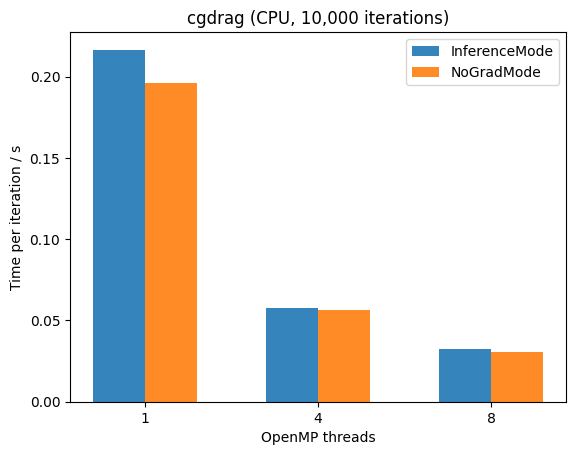

In [29]:
filtered_labels = [
    'cgdrag_torch_implicit_1_infer',
    'cgdrag_torch_implicit_1_nograd',
    'cgdrag_torch_implicit_4_infer',
    'cgdrag_torch_implicit_4_nograd',
    'cgdrag_torch_implicit_8_infer',
    'cgdrag_torch_implicit_8_nograd',
]

rb.plot_walltimes(
    benchmarks=benchmarks_infer_10k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="cgdrag (CPU, 10,000 iterations)",

    legend_labels={"_infer": "InferenceMode", "_nograd": "NoGradMode"},
    xticklabels=cpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

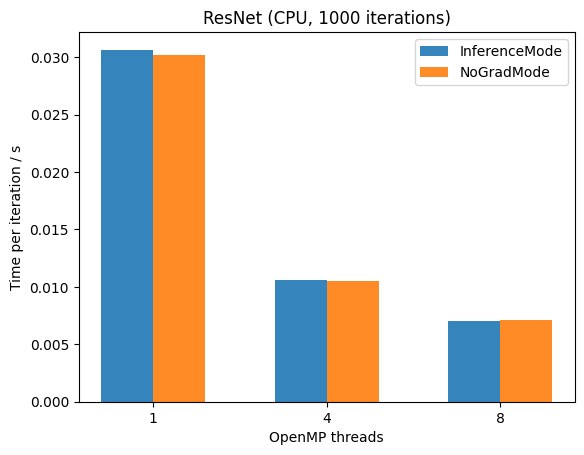

In [30]:
filtered_labels = [
    'resnet_torch_1_infer',
    'resnet_torch_1_nograd',
    'resnet_torch_4_infer',
    'resnet_torch_4_nograd',
    'resnet_torch_8_infer',
    'resnet_torch_8_nograd',
]

rb.plot_walltimes(
    benchmarks=benchmarks_infer_1k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="ResNet (CPU, 1000 iterations)",

    legend_labels={"_infer": "InferenceMode", "_nograd": "NoGradMode"},
    xticklabels=cpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

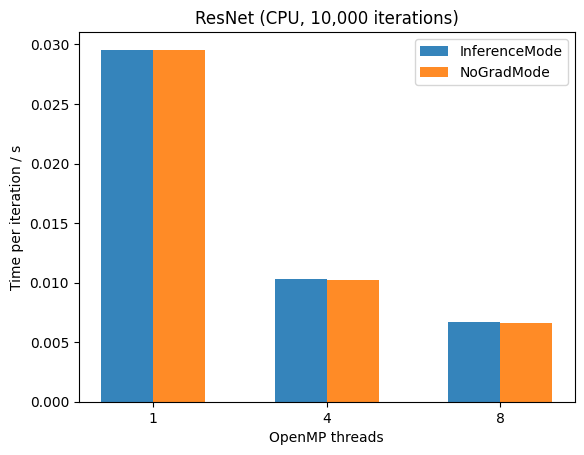

In [31]:
filtered_labels = [
    'resnet_torch_1_infer',
    'resnet_torch_1_nograd',
    'resnet_torch_4_infer',
    'resnet_torch_4_nograd',
    'resnet_torch_8_infer',
    'resnet_torch_8_nograd',
]

rb.plot_walltimes(
    benchmarks=benchmarks_infer_10k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="ResNet (CPU, 10,000 iterations)",

    legend_labels={"_infer": "InferenceMode", "_nograd": "NoGradMode"},
    xticklabels=cpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

# FTorch with InferenceMode and NoGradMode on an A100 GPU

In [32]:
# Create labels matching the order of tests in run_benchmarks.sh

gpu_infer_labels = []

gpu_tests_infer = [
    "cgdrag_torch_explicit",
    "cgdrag_torch_implicit",
    "resnet_torch",
]

gpu_tests_nograd = [
    "cgdrag_torch_explicit",
    "cgdrag_torch_implicit",
    "resnet_torch",
]

gpu_n_threads = ["1", "8"]

for threads in gpu_n_threads:
    for test in gpu_tests_infer:
        gpu_infer_labels.append(f"{test}_{threads}_infer")
for threads in gpu_n_threads:
    for test in gpu_tests_nograd:
        gpu_infer_labels.append(f"{test}_{threads}_nograd")

In [33]:
benchmarks_infer_gpu_10k = rb.read_slurm_walltime(filepath_infer_gpu_10k, gpu_infer_labels)
benchmarks_infer_gpu_100k = rb.read_slurm_walltime(filepath_infer_gpu_100k, gpu_infer_labels)

# Scale by number of iterations
for key, value in benchmarks_infer_gpu_10k.items():
    benchmarks_infer_gpu_10k[key] = value / 10000

for key, value in benchmarks_infer_gpu_100k.items():
    benchmarks_infer_gpu_100k[key] = value / 100000

Reading: ../../results/ampere_infer/output_10k/slurm-37521108.out
Reading: ../../results/ampere_infer/output_100k/slurm-37521956.out


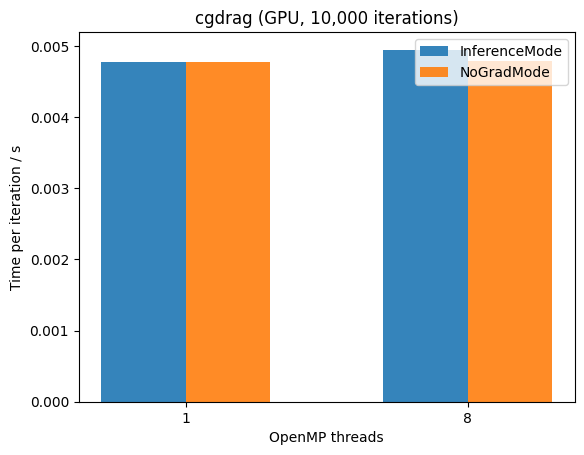

In [34]:
filtered_labels = [
    'cgdrag_torch_implicit_1_infer',
    'cgdrag_torch_implicit_1_nograd',
    'cgdrag_torch_implicit_8_infer',
    'cgdrag_torch_implicit_8_nograd',
]

rb.plot_walltimes(
    benchmarks=benchmarks_infer_gpu_10k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="cgdrag (GPU, 10,000 iterations)",

    legend_labels={"_infer": "InferenceMode", "_nograd": "NoGradMode"},
    xticklabels=gpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

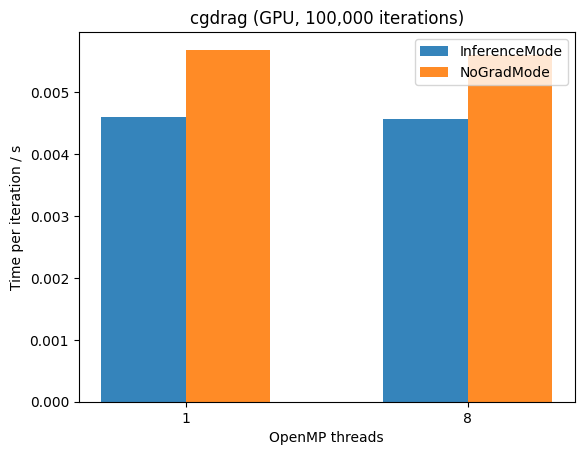

In [35]:
filtered_labels = [
    'cgdrag_torch_implicit_1_infer',
    'cgdrag_torch_implicit_1_nograd',
    'cgdrag_torch_implicit_8_infer',
    'cgdrag_torch_implicit_8_nograd',
]

rb.plot_walltimes(
    benchmarks=benchmarks_infer_gpu_100k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="cgdrag (GPU, 100,000 iterations)",

    legend_labels={"_infer": "InferenceMode", "_nograd": "NoGradMode"},
    xticklabels=gpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

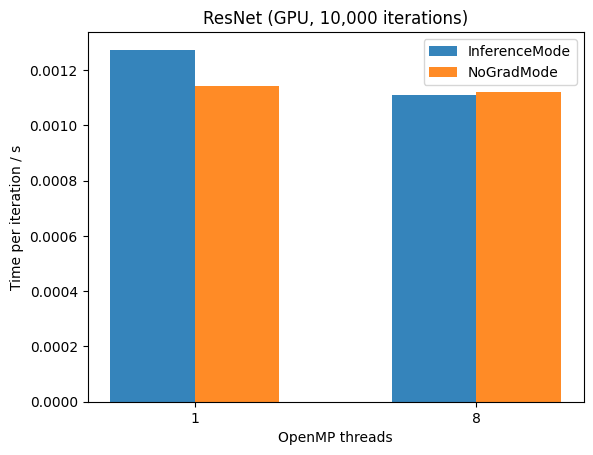

In [36]:
filtered_labels = [
    'resnet_torch_1_infer',
    'resnet_torch_1_nograd',
    'resnet_torch_8_infer',
    'resnet_torch_8_nograd',
]

rb.plot_walltimes(
    benchmarks=benchmarks_infer_gpu_10k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="ResNet (GPU, 10,000 iterations)",

    legend_labels={"_infer": "InferenceMode", "_nograd": "NoGradMode"},
    xticklabels=gpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

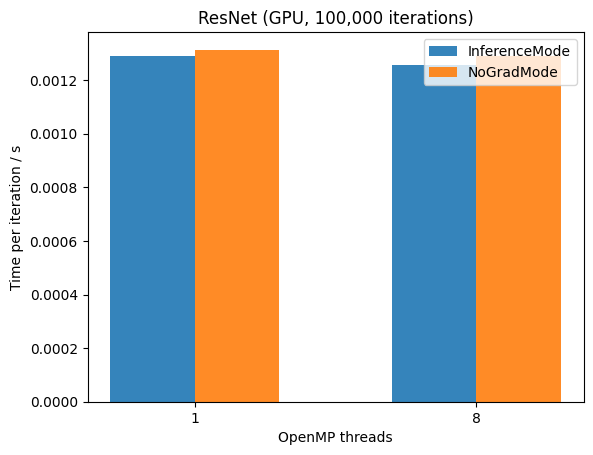

In [37]:
filtered_labels = [
    'resnet_torch_1_infer',
    'resnet_torch_1_nograd',
    'resnet_torch_8_infer',
    'resnet_torch_8_nograd',
]

rb.plot_walltimes(
    benchmarks=benchmarks_infer_gpu_100k,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="ResNet (GPU, 100,000 iterations)",

    legend_labels={"_infer": "InferenceMode", "_nograd": "NoGradMode"},
    xticklabels=gpu_n_threads,
    xlabel="OpenMP threads",

    bar_width=0.3,
)

# (Old) FTorch and Forpy on Icelake CPUs

Output files here assume the current default form of run_benchmarks.sh, e.g.:

```bash
nrun=1000

for n in {1,4,8};
do
    export OMP_NUM_THREADS=$n

    date;/usr/bin/time -v ./benchmarker_cgdrag_forpy ../cgdrag_model run_emulator_davenet      $nrun 10                    | tee cgdrag_forpy_$n.out;date
    date;/usr/bin/time -v ./benchmarker_cgdrag_torch ../cgdrag_model saved_cgdrag_model_cpu.pt $nrun 10 --explicit_reshape | tee cgdrag_torch_explicit_$n.out;date
    date;/usr/bin/time ./benchmarker_cgdrag_torch ../cgdrag_model saved_cgdrag_model_cpu.pt $nrun 10                       | tee cgdrag_torch_implicit_$n.out;date

    date;/usr/bin/time -v ./benchmarker_resnet_forpy ../resnet_model resnet18                    $nrun 10 | tee resnet_forpy_$n.out;date
    date;/usr/bin/time -v ./benchmarker_resnet_torch ../resnet_model saved_resnet18_model_cpu.pt $nrun 10 | tee resnet_torch_$n.out;date

done
```

In [38]:
# Create labels matching the order of tests in run_benchmarks.sh

cpu_tests = [
    "cgdrag_forpy",
    "cgdrag_torch_explicit",
    "cgdrag_torch_implicit",
    "resnet_forpy",
    "resnet_torch",
]

cpu_n_threads = ["1", "4", "8"]
cpu_labels = []

for threads in cpu_n_threads:
    for test in cpu_tests:
        cpu_labels.append(f"{test}_{threads}")


gpu_tests = [
    "cgdrag_forpy_gpu",
    "cgdrag_torch_explicit_gpu",
    "cgdrag_torch_implicit_gpu",
    "resnet_forpy_gpu",
    "resnet_torch_gpu",
]

gpu_n_threads = ["1", "8"]
gpu_labels = []

for threads in gpu_n_threads:
    for test in gpu_tests:
        gpu_labels.append(f"{test}_{threads}")

In [39]:
benchmarks_nograd_fix_1k = rb.read_slurm_walltime(filepath_nograd_fix_1k, cpu_labels)
benchmarks_nograd_fix_10k = rb.read_slurm_walltime(filepath_nograd_fix_10k, cpu_labels)

Reading: ../../results/icelake_nograd/output_1000_fix/slurm-34050567.out
Reading: ../../results/icelake_nograd/output_10000_fix/slurm-34051232.out


In [40]:
benchmarks_nograd_fix = {}

for key, value in benchmarks_nograd_fix_1k.items():
    benchmarks_nograd_fix[key + "_1k"] = value / 1000

for key, value in benchmarks_nograd_fix_10k.items():
    benchmarks_nograd_fix[key + "_10k"] = value / 10000

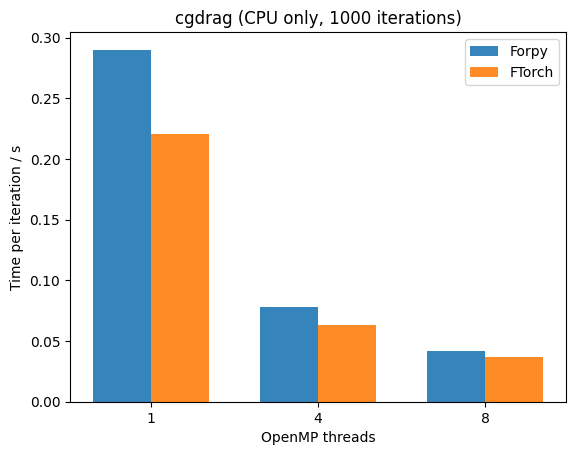

In [41]:
filtered_labels = [
    label for label in benchmarks_nograd_fix.keys() if (
        "cgdrag" in label and "10k" not in label and ("forpy" in label or "torch_implicit" in label)
    )
]
rb.plot_walltimes(
    benchmarks=benchmarks_nograd_fix,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="cgdrag (CPU only, 1000 iterations)",

    legend_labels={"forpy": "Forpy", "torch": "FTorch"},
    xticklabels=cpu_n_threads,
    xlabel="OpenMP threads",

    # legend_labels={"_1_": "1", "_4_": "4", "_8_": "8"},
    # xticklabels=["Forpy", "FTorch"],
    # xlabel="PyTorch interface",

    bar_width=0.35,
    save_path="plots/cgdrag_1000.jpg"
)

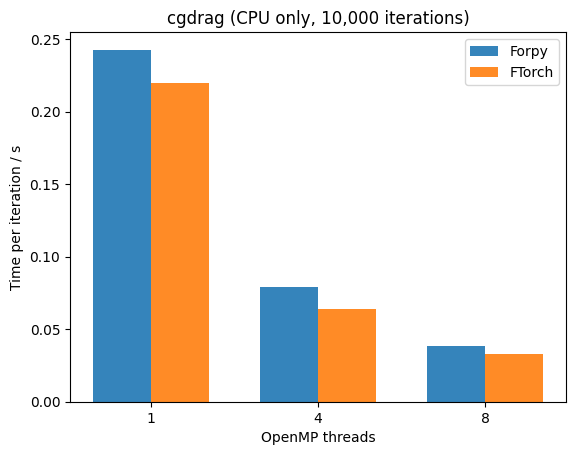

In [42]:
filtered_labels = [
    label for label in benchmarks_nograd_fix.keys() if (
        "cgdrag" in label and "10k" in label and ("forpy" in label or "torch_implicit" in label)
    )
]
rb.plot_walltimes(
    benchmarks=benchmarks_nograd_fix,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="cgdrag (CPU only, 10,000 iterations)",

    legend_labels={"forpy": "Forpy", "torch": "FTorch"},
    xticklabels=cpu_n_threads,
    xlabel="OpenMP threads",

    # legend_labels={"_1_": "1", "_4_": "4", "_8_": "8"},
    # xticklabels=["Forpy", "FTorch"],
    # xlabel="PyTorch interface",

    bar_width=0.35,
)

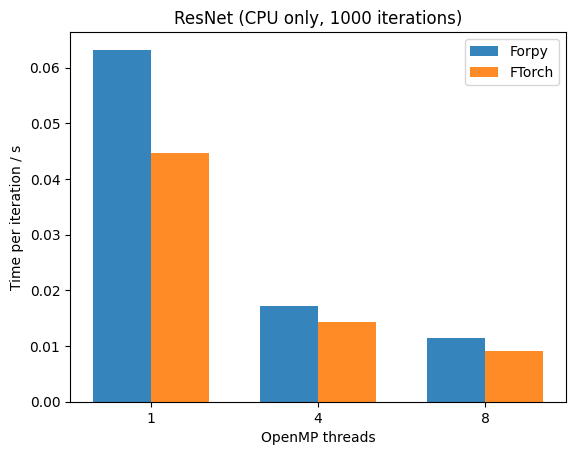

In [43]:
filtered_labels = [
    label for label in benchmarks_nograd_fix.keys() if ("resnet" in label and "10k" not in label)
]
rb.plot_walltimes(
    benchmarks=benchmarks_nograd_fix,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="ResNet (CPU only, 1000 iterations)",

    legend_labels={"forpy": "Forpy", "torch": "FTorch"},
    xticklabels=cpu_n_threads,
    xlabel="OpenMP threads",

    # legend_labels={"_1_": "1", "_4_": "4", "_8_": "8"},
    # xticklabels=["Forpy", "FTorch"],
    # xlabel="PyTorch interface",

    bar_width=0.35,
)

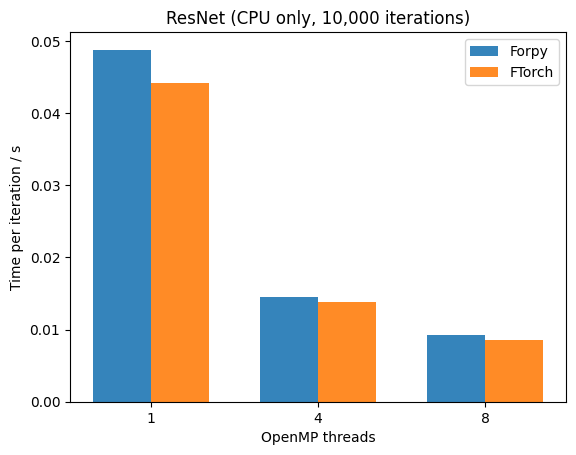

In [44]:
filtered_labels = [
    label for label in benchmarks_nograd_fix.keys() if ("resnet" in label and "10k" in label)
]
rb.plot_walltimes(
    benchmarks=benchmarks_nograd_fix,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="ResNet (CPU only, 10,000 iterations)",

    legend_labels={"forpy": "Forpy", "torch": "FTorch"},
    xticklabels=cpu_n_threads,
    xlabel="OpenMP threads",
    ylim=0.,

    # legend_labels={"_1_": "1", "_4_": "4", "_8_": "8"},
    # xticklabels=["Forpy", "FTorch"],
    # xlabel="PyTorch interface",

    bar_width=0.35,
)

# (Old) FTorch and Forpy on A100 GPUs

In [45]:
benchmarks_nograd_fix_gpu_10k = rb.read_slurm_walltime(filepath_nograd_fix_gpu_10k, gpu_labels)
benchmarks_nograd_fix_gpu_100k = rb.read_slurm_walltime(filepath_nograd_fix_gpu_100k, gpu_labels)

Reading: ../../results/ampere_nograd/output_10000_fix/slurm-34050397.out
Reading: ../../results/ampere_nograd/output_100000_fix/slurm-34051212.out


In [46]:
benchmarks_nograd_fix_gpu = {}

for key, value in benchmarks_nograd_fix_gpu_10k.items():
    benchmarks_nograd_fix_gpu[key + "_10k"] = value / 10000

for key, value in benchmarks_nograd_fix_gpu_100k.items():
    benchmarks_nograd_fix_gpu[key + "_100k"] = value / 100000

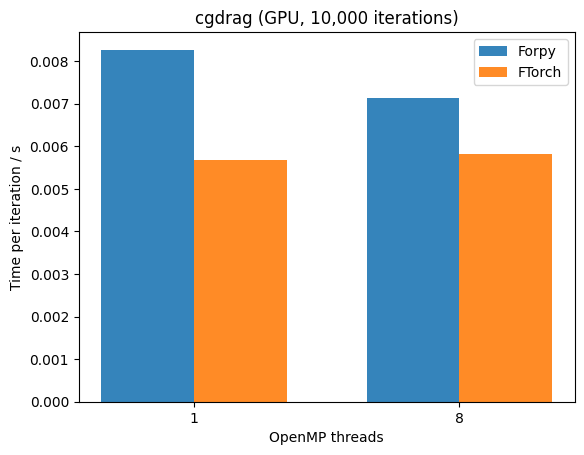

In [47]:
filtered_labels = [
    label for label in benchmarks_nograd_fix_gpu.keys() if (
        ("cgdrag_forpy" in label or "cgdrag_torch_implicit" in label) and "100k" not in label
    )
]
rb.plot_walltimes(
    benchmarks=benchmarks_nograd_fix_gpu,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="cgdrag (GPU, 10,000 iterations)",

    legend_labels={"forpy": "Forpy", "torch": "FTorch"},
    xticklabels=gpu_n_threads,
    xlabel="OpenMP threads",

    # legend_labels={"_1_": "1", "_8_": "8"},
    # xticklabels=["Forpy", "FTorch"],
    # xlabel="PyTorch interface",

    bar_width=0.35,
)

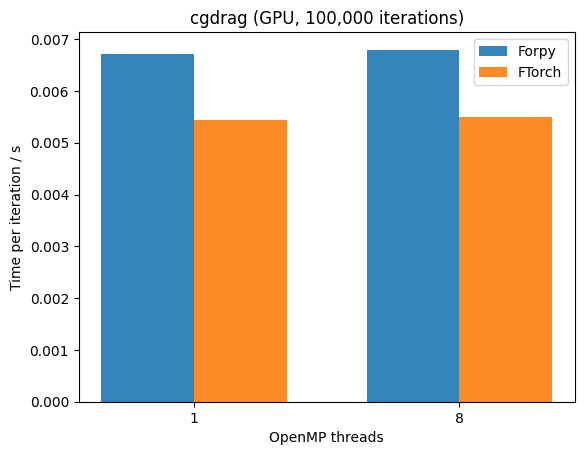

In [48]:
filtered_labels = [
    label for label in benchmarks_nograd_fix_gpu.keys() if (
        ("cgdrag_forpy" in label or "cgdrag_torch_implicit" in label) and "100k" in label
    )
]
rb.plot_walltimes(
    benchmarks=benchmarks_nograd_fix_gpu,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="cgdrag (GPU, 100,000 iterations)",

    legend_labels={"forpy": "Forpy", "torch": "FTorch"},
    xticklabels=gpu_n_threads,
    xlabel="OpenMP threads",

    # legend_labels={"_1_": "1", "_8_": "8"},
    # xticklabels=["Forpy", "FTorch"],
    # xlabel="PyTorch interface",

    bar_width=0.35,
)

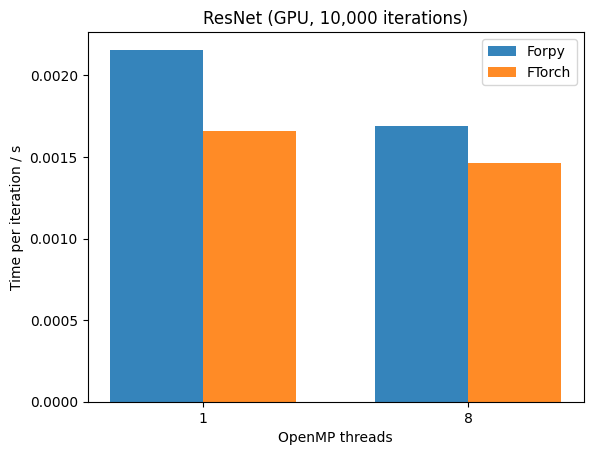

In [49]:
filtered_labels = [
    label for label in benchmarks_nograd_fix_gpu.keys() if ("resnet" in label and "100k" not in label)
]
rb.plot_walltimes(
    benchmarks=benchmarks_nograd_fix_gpu,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="ResNet (GPU, 10,000 iterations)",

    legend_labels={"forpy": "Forpy", "torch": "FTorch"},
    xticklabels=gpu_n_threads,
    xlabel="OpenMP threads",

    # legend_labels={"_1_": "1", "_8_": "8"},
    # xticklabels=["Forpy", "FTorch"],
    # xlabel="PyTorch interface",

    bar_width=0.35,
)

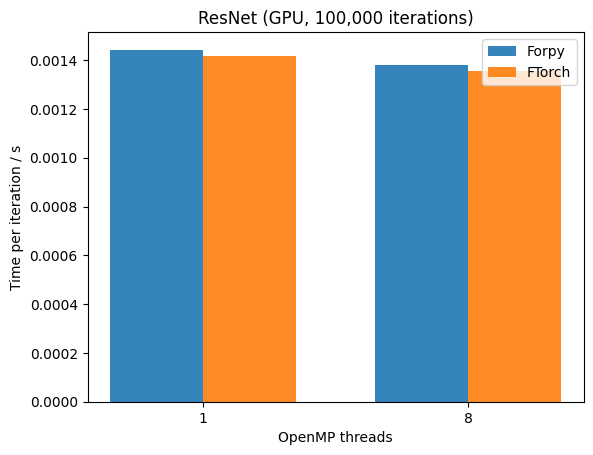

In [50]:
filtered_labels = [
    label for label in benchmarks_nograd_fix_gpu.keys() if ("resnet" in label and "100k" in label)
]
rb.plot_walltimes(
    benchmarks=benchmarks_nograd_fix_gpu,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="ResNet (GPU, 100,000 iterations)",

    legend_labels={"forpy": "Forpy", "torch": "FTorch"},
    xticklabels=gpu_n_threads,
    xlabel="OpenMP threads",

    # legend_labels={"_1_": "1", "_8_": "8"},
    # xticklabels=["Forpy", "FTorch"],
    # xlabel="PyTorch interface",

    bar_width=0.35,
)

# (Old) FTorch and Forpy on CPU and GPU

In [51]:
benchmarks_nograd_fix_gpu_cpu = {}

for key, value in benchmarks_nograd_fix.items():
    if ("_8" in key and "10k" in key):
        benchmarks_nograd_fix_gpu_cpu[key] = value
for key, value in benchmarks_nograd_fix_gpu.items():
    if ("_8" in key and "100k" not in key):
        benchmarks_nograd_fix_gpu_cpu[key] = value

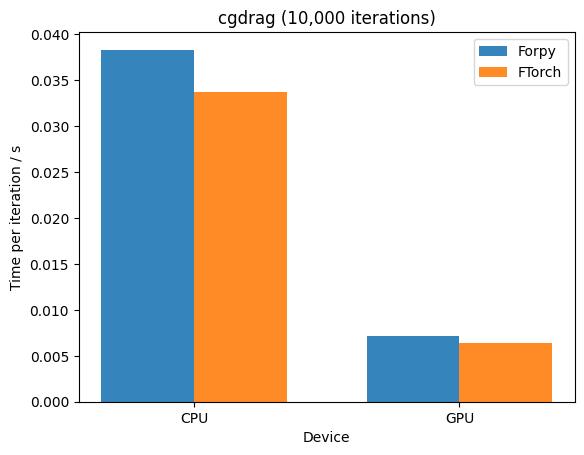

In [52]:
filtered_labels = [
    label for label in benchmarks_nograd_fix_gpu_cpu.keys() if (
        "cgdrag_torch_explicit" in label or "cgdrag_forpy" in label
    )
]
rb.plot_walltimes(
    benchmarks=benchmarks_nograd_fix_gpu_cpu,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="cgdrag (10,000 iterations)",

    legend_labels={"forpy": "Forpy", "torch": "FTorch"},
    xticklabels=["CPU", "GPU"],
    xlabel="Device",
    # yscale="log",
    # ylim=(0.005, 0.1),

    # legend_labels={"_1_": "1", "_8_": "8"},
    # xticklabels=["Forpy", "FTorch"],
    # xlabel="PyTorch interface",

    bar_width=0.35,
)

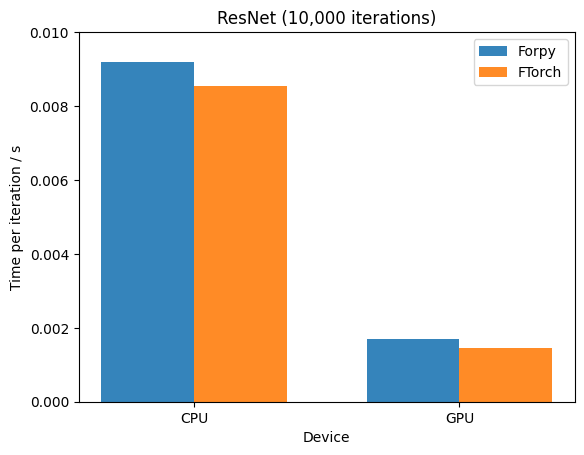

In [53]:
filtered_labels = [
    label for label in benchmarks_nograd_fix_gpu_cpu.keys() if ("resnet" in label)
]
rb.plot_walltimes(
    benchmarks=benchmarks_nograd_fix_gpu_cpu,
    labels=filtered_labels,
    ylabel="Time per iteration / s",
    title="ResNet (10,000 iterations)",

    legend_labels={"forpy": "Forpy", "torch": "FTorch"},
    xticklabels=["CPU", "GPU"],
    xlabel="Device",
    # yscale="log",
    ylim=(0., 0.01),

    # legend_labels={"_1_": "1", "_8_": "8"},
    # xticklabels=["Forpy", "FTorch"],
    # xlabel="PyTorch interface",

    bar_width=0.35,
)